In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/Models/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/home/himanshu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### importing libraries

To begin with, we need to import several libraries to enable us to perform various tasks related to data visualization, image processing, and machine learning.

In [2]:
import matplotlib.pyplot as plt
from PIL import Image


### loading the dataset

In [4]:
root="../dog-breeds"

In [5]:
dogs=os.listdir(root)
dogs

['rottweiller',
 'bulldog',
 'dalmatian',
 'german-spherad',
 'labrador-retriever',
 'husky',
 'poodle',
 'beagle']

### Creation of dataframe


In [6]:
images=[]
dog_breed=[]
for dog in dogs:
    directory=root +  "/" + dog + "/"
    for image in os.listdir(directory):
        images.append(directory + image)
        dog_breed.append(dog)   

In [7]:
Images = pd.Series(images, name="Image").astype(str)

In [7]:
Images.head()

0    /kaggle/input/dog-breeds/dog-breeds/husky/husk...
1    /kaggle/input/dog-breeds/dog-breeds/husky/husk...
2    /kaggle/input/dog-breeds/dog-breeds/husky/husk...
3    /kaggle/input/dog-breeds/dog-breeds/husky/husk...
4    /kaggle/input/dog-breeds/dog-breeds/husky/husk...
Name: Image, dtype: object

In [8]:
dog_breed=pd.Series(dog_breed, name="BREED")
data=pd.concat([Images, dog_breed], axis=1)
data.head()

,Image,BREED
0,/kaggle/input/dog-breeds/dog-breeds/husky/husk...,husky
1,/kaggle/input/dog-breeds/dog-breeds/husky/husk...,husky
2,/kaggle/input/dog-breeds/dog-breeds/husky/husk...,husky
3,/kaggle/input/dog-breeds/dog-breeds/husky/husk...,husky
4,/kaggle/input/dog-breeds/dog-breeds/husky/husk...,husky


In [9]:
data=data.sample(frac=1).reset_index(drop = True)

In [10]:
data

,Image,BREED
0,/kaggle/input/dog-breeds/dog-breeds/german-she...,german-shepherd
1,/kaggle/input/dog-breeds/dog-breeds/labrador-r...,labrador-retriever
2,/kaggle/input/dog-breeds/dog-breeds/dalmatian/...,dalmatian
3,/kaggle/input/dog-breeds/dog-breeds/beagle/bea...,beagle
4,/kaggle/input/dog-breeds/dog-breeds/labrador-r...,labrador-retriever
...,...,...
536,/kaggle/input/dog-breeds/dog-breeds/husky/husk...,husky
537,/kaggle/input/dog-breeds/dog-breeds/rottweiler...,rottweiler
538,/kaggle/input/dog-breeds/dog-breeds/rottweiler...,rottweiler
539,/kaggle/input/dog-breeds/dog-breeds/rottweiler...,rottweiler


In [11]:
data.shape

(541, 2)

### Image visualization


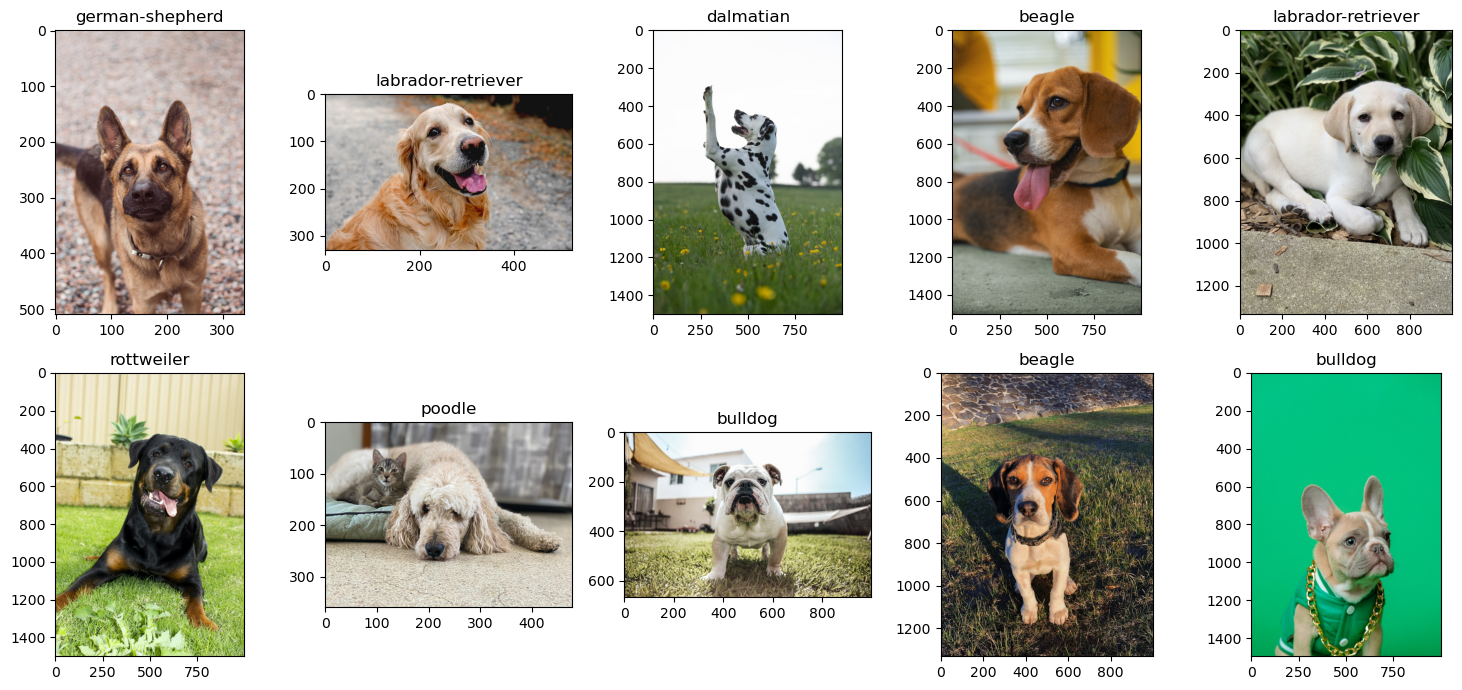

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7))

for i, ax in enumerate(axes.flat):
    ax.imshow(Image.open(data.loc[i, "Image"]))
    ax.set_title(data.loc[i, "BREED"])
plt.tight_layout()
plt.show()

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
dev, test =train_test_split(data, train_size=0.9, shuffle=True, random_state=42)

### ImageDataGenerator 

In [18]:
import keras
from keras.preprocessing.image import ImageDataGenerator

### flow from dataframe

In [19]:
dev_generator = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2, 
    zoom_range=0.2,
    fill_mode="nearest",
    validation_split=0.2
)

In [20]:
test_generator = ImageDataGenerator(
    rescale=1./255
)

### train

In [21]:
train_images = dev_generator.flow_from_dataframe(
    dataframe=dev,
    x_col='Image',
    y_col='BREED',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

Found 389 validated image filenames belonging to 8 classes.


### validate

In [22]:
val_images = dev_generator.flow_from_dataframe(
    dataframe=dev,
    x_col='Image',
    y_col='BREED',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 97 validated image filenames belonging to 8 classes.


### test 

In [23]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test,
    x_col='Image',
    y_col='BREED',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode=None,
    batch_size=32,
    shuffle=False
)

Found 55 validated image filenames.


In [24]:
!pip install tensorflow
!pip install keras


### ResNet50V2 Model for Image Classification


**The following code demonstrates the implementation of a ResNet50V2 model for image classification using Keras. The ResNet50V2 model is pre-trained on the ImageNet dataset and is used as a feature extractor**

### Code Explanation

    1. Importing Dependencies: We begin by importing the necessary dependencies, including the ResNet model from Keras, as well as other required layers and callbacks

In [45]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.applications import ResNet50V2

     2. Defining Input Shape and Base Model:
    We define the desired input image size (64x64x3) and initialize the MobileNet model as the base model. The include_top=False argument ensures that the top classification layer of the MobileNet model is excluded.​

In [46]:
# Define the desired input image size
input_shape = (224, 224, 3)


In [47]:
# Initialize the MobileNet model as the base model
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape)



    3. Freezing Base Model Layers:
     We freeze the base model layers to prevent their weights from being updated during training. This is beneficial when dealing with limited training data to avoid overfitting and leverage the pre-trained weights.​

In [48]:
# Freeze the layers in the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a Sequential model
model = Sequential()

# Add the base model as the first layer
model.add(base_model)

    4. Building the Model Architecture:
    A sequential model is created. The base EfficientNetB0 model is added as the first layer. Global average pooling is applied to reduce the spatial dimensions of the output. Dropout layers are introduced to mitigate overfitting. Two dense layers with ReLU activation are added, followed by a final dense layer with softmax activation for multi-class classification.

In [49]:

# Add additional layers for classification
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

    5. Compiling the Model:
    We compile the model by specifying the loss function, optimizer, and evaluation metrics. In this case, we use categorical cross-entropy as the loss function, the Adam optimizer, and track accuracy as evaluation metrics.

In [50]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'mse'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_4 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 256)              

    6. Training the Model: 
    We fit the model to the training data (`train_images`) and validate it on the validation data (`val_images`) using the provided training parameters after defining `earlystopping` and reduction in learning rate using `reduce_lr`


In [54]:
# Training the model
batch_size = 32
history = model.fit(train_images, validation_data=val_images, epochs=15, batch_size=batch_size, callbacks=[EarlyStopping(patience=3), ReduceLROnPlateau()])


Epoch 1/15
13/13 [==============================] - 12s 915ms/step - loss: 0.1324 - accuracy: 0.9563 - mse: 0.0083 - val_loss: 0.1324 - val_accuracy: 0.9588 - val_mse: 0.0071 - lr: 0.0010
Epoch 2/15
13/13 [==============================] - 11s 881ms/step - loss: 0.1172 - accuracy: 0.9666 - mse: 0.0061 - val_loss: 0.0905 - val_accuracy: 0.9794 - val_mse: 0.0043 - lr: 0.0010
Epoch 3/15
13/13 [==============================] - 11s 836ms/step - loss: 0.0874 - accuracy: 0.9820 - mse: 0.0051 - val_loss: 0.0766 - val_accuracy: 0.9691 - val_mse: 0.0058 - lr: 0.0010
Epoch 4/15
13/13 [==============================] - 11s 860ms/step - loss: 0.1036 - accuracy: 0.9614 - mse: 0.0067 - val_loss: 0.0624 - val_accuracy: 0.9794 - val_mse: 0.0040 - lr: 0.0010
Epoch 5/15
13/13 [==============================] - 11s 843ms/step - loss: 0.1108 - accuracy: 0.9640 - mse: 0.0069 - val_loss: 0.1868 - val_accuracy: 0.9588 - val_mse: 0.0098 - lr: 0.0010
Epoch 6/15
13/13 [==============================] - 11s 813m

    7.Conclusion
     we have implemented a ResNet50V2 model for image classification using Keras. The ResNet50V2 model, pre-trained on the ImageNet dataset, serves as a powerful feature extractor. By freezing the pre-trained layers and adding additional layers for classification, we were able to achieve good performance on our image classification task..

###  Training and Validation Metrics Visualization

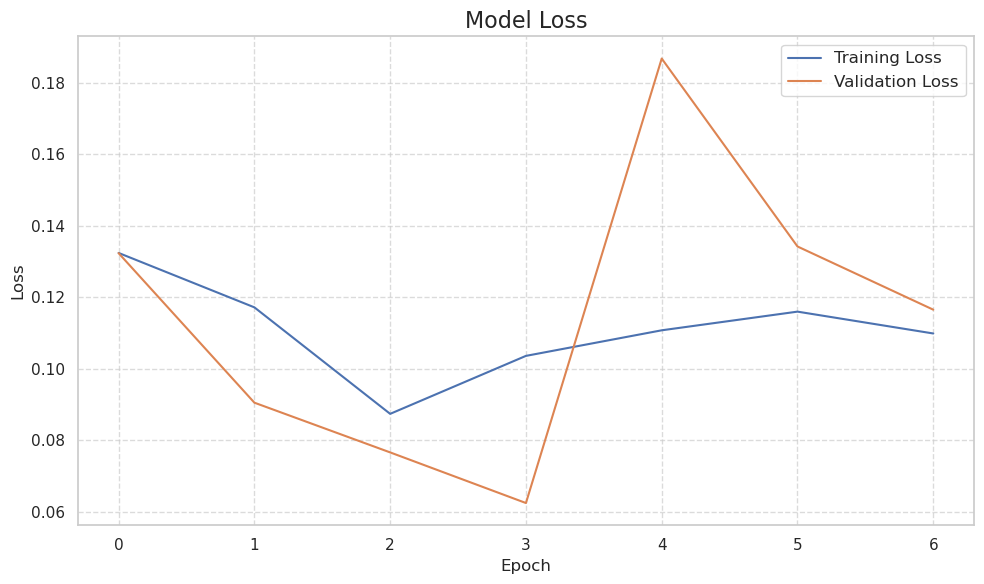

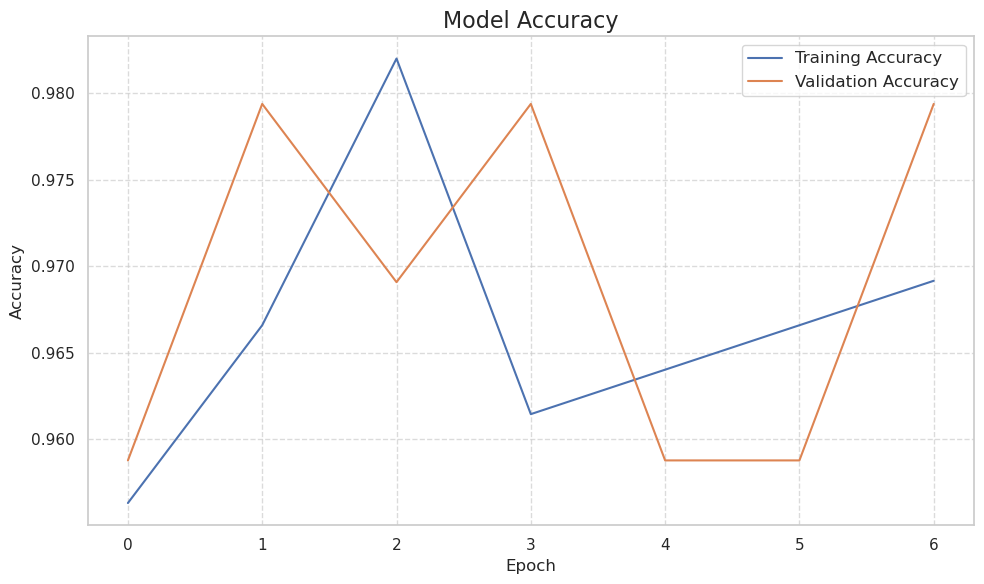

In [56]:
# Plot model loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot model accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Training and Validation Metrics Visualization

In [57]:
img_pred=model.predict(test_images)
img_pred=np.argmax(img_pred, axis=1)

2/2 [==============================] - 3s 2s/step


In [58]:
final=train_images.class_indices
final

{'beagle': 0,
 'bulldog': 1,
 'dalmatian': 2,
 'german-shepherd': 3,
 'husky': 4,
 'labrador-retriever': 5,
 'poodle': 6,
 'rottweiler': 7}

In [59]:
labels = dict((v,k) for k,v in final.items())
y_pred = [labels[k] for k in img_pred]

In [60]:
test.reset_index(drop=True, inplace=True)

###  accuracy evaluation

In [61]:
from sklearn.metrics import accuracy_score, classification_report

In [62]:
y_test=test["BREED"].values

In [63]:
accuracy_score(y_pred, y_test)

0.9818181818181818

In [64]:
print(classification_report(y_test, y_pred))    

                    precision    recall  f1-score   support

            beagle       1.00      1.00      1.00         7
           bulldog       1.00      0.92      0.96        12
         dalmatian       1.00      1.00      1.00         7
   german-shepherd       0.88      1.00      0.93         7
             husky       1.00      1.00      1.00         8
labrador-retriever       1.00      1.00      1.00         1
            poodle       1.00      1.00      1.00         8
        rottweiler       1.00      1.00      1.00         5

          accuracy                           0.98        55
         macro avg       0.98      0.99      0.99        55
      weighted avg       0.98      0.98      0.98        55



### Visualizing Predicted Labels

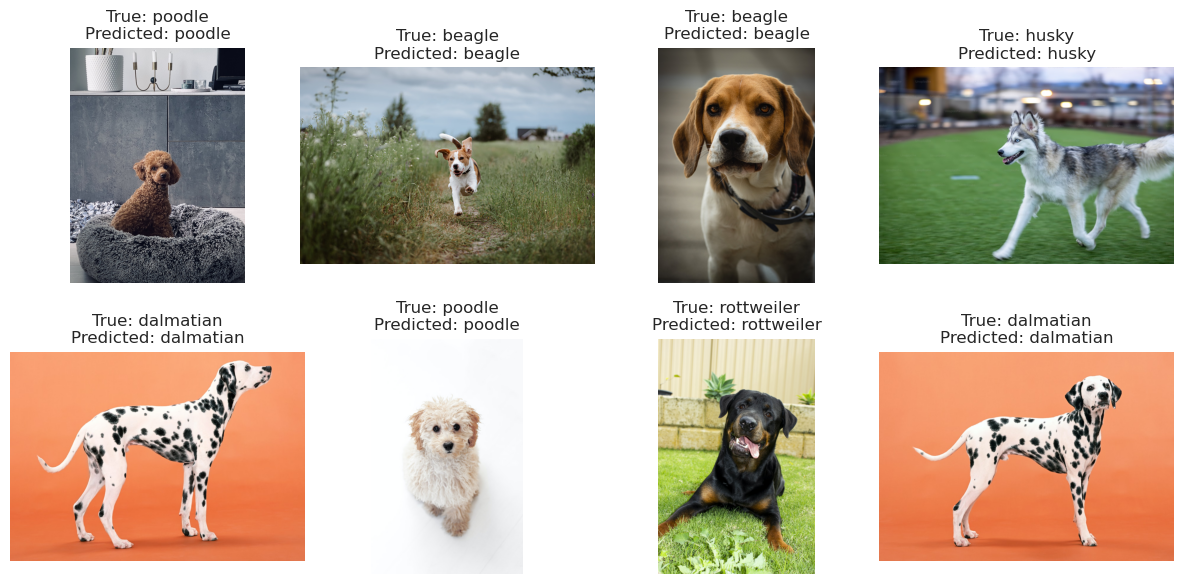

In [65]:
import random
import matplotlib.pyplot as plt
from PIL import Image

# Assuming you have a DataFrame called 'test' containing image paths and labels

num_images = 8
rows = 2
cols = num_images // rows

# Generate random indices to select unique images
indices = random.sample(range(test.shape[0]), num_images)

fig, axes = plt.subplots(rows, cols, figsize=(12, 6))

for i in range(num_images):
    row = i // cols
    col = i % cols
    index = indices[i]
    img_path = test.loc[index, "Image"]
    true_label = test.loc[index, "BREED"]
    predicted_label = y_pred[index]
    
    img = Image.open(img_path)
    axes[row, col].imshow(img)
    axes[row, col].set_title(f"True: {true_label}\nPredicted: {predicted_label}")
    axes[row, col].axis("off")

plt.tight_layout()
plt.show()


###  confusion matrix

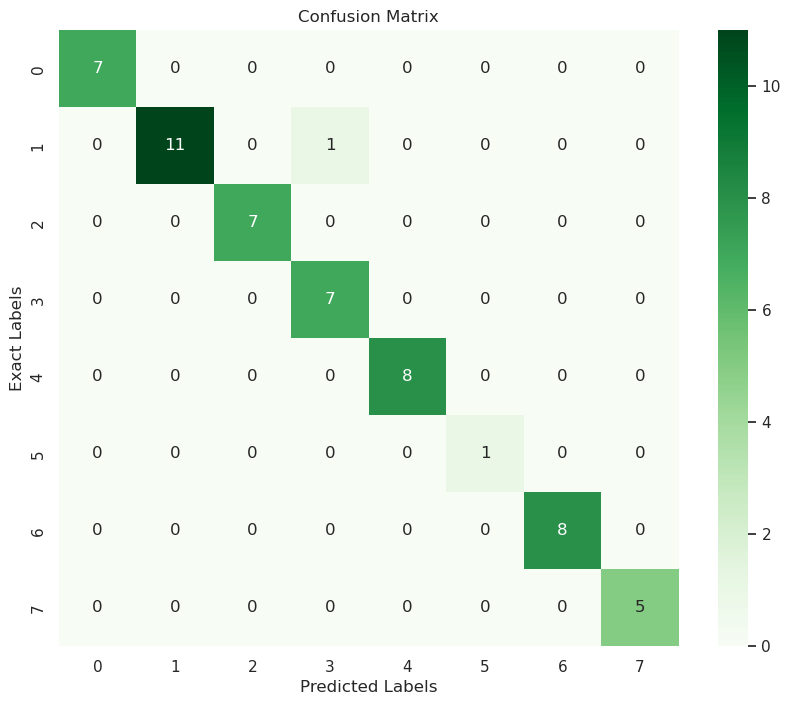

In [66]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("Exact Labels")
plt.show()

Saving the model

In [ ]:
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape) 
# Freeze the layers in the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a Sequential model
model = Sequential()

# Add the base model as the first layer
model.add(base_model)


# Add additional layers for classification
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'mse'])
model.summary()

# Training the model and saving the best

batch_size = 32
history = model.fit(train_images, validation_data=val_images, epochs=15, batch_size=batch_size, callbacks=[ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min'),EarlyStopping(patience=3), ReduceLROnPlateau()])